<a href="https://colab.research.google.com/github/kylemath/DeepEEG/blob/master/notebooks/DeepEEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DeepEEG


In [1]:
!git clone https://github.com/kylemath/DeepEEG
!chmod +x ./DeepEEG/install.sh
!./DeepEEG/install.sh
from DeepEEG.utils import *
%matplotlib inline


Cloning into 'DeepEEG'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 506 (delta 102), reused 77 (delta 33), pack-reused 316
Receiving objects: 100% (506/506), 17.75 MiB | 8.58 MiB/s, done.
Resolving deltas: 100% (232/232), done.
    100% |████████████████████████████████| 6.2MB 5.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/59/23/bb/ebafe2eae31064edfb9b384131abd0ec562a9418601cde6d69
Successfully built mne


Using TensorFlow backend.


#Connect to Google Drive

In [8]:
#mount google drive to load own images, follow link and get code and paste in below
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#Run Brain Recorder Loading Data

*  Each data file is from a condition in an EEG experiment, from folder in google drive


In [25]:
#Data Settings#
path = 'gdrive/My Drive/data/'
exp = 'bikepark'
conditions = ['quiet','traffic']
subs = ['005', '007', '009', '010', '012', '013', '014', '015', '016', '019']
subs = [ '015']

event_names = ['Standard','Target']
event_nums = [1,2] # 1 Standard, 2 Target, 9 Response

#exp = 'P2_Soundz'
#conditions = ['']
#subs = ['001', '003', '004', '005', '006', '007', '009', '010', '011', '012', '013', '015', '016', '017'];#P2_Sounds
#subs = ['006']
#event_names = ['Standard/Silent','Standard/Sound','Standard/White','Standard/Silent_Low',
#               'Target/Silent','Target/Sound','Target/White','Target/Silent_Low']
#event_nums = [1,8,5,7,2,3,6,9]


for isub,sub in enumerate(subs):       
  print('Loading data for subject number: ' + sub)
  
  
  for icond, condition in enumerate(conditions):
    
    if len(conditions) > 1:
      fname = path + exp + '/' + sub + '_' + exp + '_' + condition + '.vhdr'
    else:
      fname = path + exp + '/' + sub + '_' + exp + '.vhdr'
      
    tempraw,sfreq = load_data(fname,data_type='recorder',plot_sensors=False,plot_raw=False,plot_raw_psd=False,stim_channel=True)
    if icond==0 and isub==0:
      raw = tempraw
    else:
      raw.append(tempraw)

Loading data for subject number: 015
Extracting parameters from gdrive/My Drive/data/bikepark/015_bikepark_quiet.vhdr...
Setting channel info structure...
Reading 0 ... 1262439  =      0.000 ...  2524.878 secs...


DeepEEG/utils.py:62: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/015_bikepark_traffic.vhdr...
Setting channel info structure...
Reading 0 ... 940909  =      0.000 ...  1881.818 secs...


DeepEEG/utils.py:62: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S 15', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations


<ipython-input-25-27472e515fa9>:34: RuntimeWarning: Omitted 1211 annotation(s) that were outside data range.
  raw.append(tempraw)


#Load Muse Data from eeg-notebooks

In [2]:
print('Muse data load')
!git clone https://github.com/kylemath/eeg-notebooks/

#Parameters#
#subject folders in data folder
subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
        202, 203, 204, 205, 207, 208, 209, 210, 211, 
        301, 302, 303, 304, 305, 306, 307, 308, 309]

data_dir = 'visual/cueing'
event_names = ['LeftCue','RightCue']
nsesh = 2
load_verbose = True


#for testing
#subs = [ 205, 207, 208, 209]
subs = [2]
nsesh = 1
#number of sessions in each subject folder

## Can load other experiments like this - NN and CNN model works great
#subs = [ 1]
#nsesh = 1
#data_dir = 'visual/P300'
#event_names = ['Standard','Target']
##

## Can load other experiments like this - NN and CNN model works best here
#subs = [ 4]
#nsesh = 1
#data_dir = 'visual/SSVEP'
#event_names = ['f30Hz','f20Hz']

##

sfreq = 256.
event_nums = [1,2]

#Load Data
print('Loading Data')
isub = subs[0]
raw = muse_load_data(data_dir, sfreq=sfreq ,subject_nb=isub, session_nb=1,verbose=load_verbose)
if nsesh == 2:
  raw.append(muse_load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2,verbose=load_verbose))

if len(subs)>1:
  for isub in subs[1:]:
    print(isub)
    raw.append(muse_load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=1,verbose=load_verbose))
    if nsesh == 2:
      raw.append(muse_load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2,verbose=load_verbose))
  



  
  

Muse data load
Cloning into 'eeg-notebooks'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 1792 (delta 7), reused 0 (delta 0), pack-reused 1776
Receiving objects: 100% (1792/1792), 110.45 MiB | 13.07 MiB/s, done.
Resolving deltas: 100% (785/785), done.
Checking out files: 100% (487/487), done.
Loading Data
Creating RawArray with float64 data, n_channels=5, n_times=51048
    Range : 0 ... 51047 =      0.000 ...   199.402 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=51048
    Range : 0 ... 51047 =      0.000 ...   199.402 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=51060
    Range : 0 ... 51059 =      0.000 ...   199.449 secs
Ready.


#Run Preprocessing

Filtering Data
2418 events found
Event IDs: [  1   2   3   4   5   6   7   9  11  15 255]
('sample drop %: ', 100)


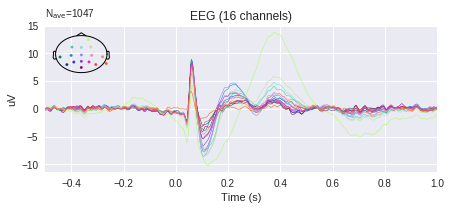

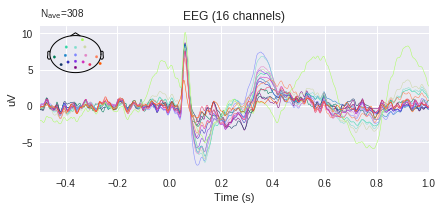

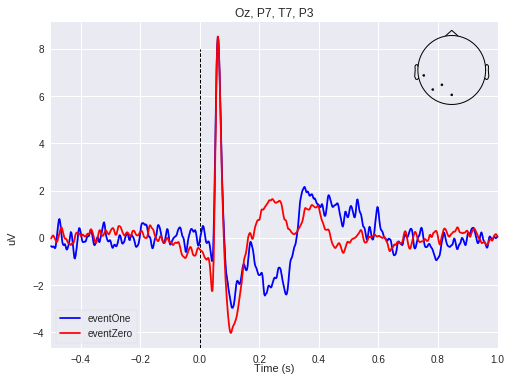

In [26]:
##Preprocessing Settings
event_id = {event_names[1]: event_nums[1], event_names[0]: event_nums[0]} #create dict

epochs = PreProcess(raw, event_id, rej_thresh_uV=200,
                    plot_psd=False,plot_events=False,plot_erp=True,
                   epoch_time=(-.5,1), baseline=(-.5,0))
                    

#plot_psd=False, filter_data=True, 
#eeg_filter_highpass=1, plot_events=False, , 
# rej_thresh_uV=150,
#epoch_decim=1, plot_electrodes=True,
#plot_erp=True

#keep epoch_decim=1 if using frequency_domain


#Run FeatureEngineer

In [39]:
#change this so epochs can either be a mne epochs object, 
#or can be an encoded latent space from the autoencoder
#automatically detects type
feats = FeatureEngineer( epochs, model_type = 'NN',
                          frequency_domain=0,wave_cycles=3,flims=(4,20),f_bins=10,
                          spect_baseline=[-1,-.5],wavelet_decim=5, electrode_median=True,  
                         electrodes_out=[7,8,9,10,11,12,13,14,15]
                       )
                             
#frequency_domain=0, 
#normalization=True,
#electrode_median=False,          #not tested for freq domain

#wavelet_decim=1,flims=(2,30),  
#f_bins=20,wave_cycles=3,
#spect_baseline=[-1,-.5],
#electrodes_out= [13,14,15],
#test_split = 0.2, val_split = 0.2,

#random_seed=1017

Constructing Time Domain Features
Computing Median over electrodes
Normalizing X
Combined X Shape: (1355, 500, 1)
Combined Y Shape: (1355,)
Y Example (should be 1s & 0s): [0 1 0 0 0 0 0 0 0 0]
X Range: -5.068643:7.6042924
Input Shape: (500, 1)
('x_train shape:', (813, 500, 1))
(813, 'train samples')
(271, 'test samples')
(271, 'validation samples')
Class Weights: [0.6452381  2.22131148]


# Run CreateModel

In [40]:
model, encoder = CreateModel(feats, 
                             units=[16,8,4,8],
                             dropout=.25,batch_norm=False,
                             filt_size=(20,2),pool_size=(10,2)
                            ) 

  
#use uneven tupples to make filters and pooling longer in time dimension


Creating NN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                8016      
_________________________________________________________________
activation_37 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 136       
_________________________________________________________________
activation_38 (Activation)   (None, 8)                 0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8)                 0  

# TrainTestVal

Training Model:
Train on 813 samples, validate on 271 samples
Epoch 1/20
813/813 [==============================] - 2s 3ms/step - loss: 0.8461 - acc: 0.4182 - val_loss: 0.7217 - val_acc: 0.3801
Epoch 2/20
813/813 [==============================] - 0s 63us/step - loss: 0.7509 - acc: 0.5215 - val_loss: 0.7014 - val_acc: 0.5018
Epoch 3/20
813/813 [==============================] - 0s 47us/step - loss: 0.7277 - acc: 0.5732 - val_loss: 0.6886 - val_acc: 0.6421
Epoch 4/20
813/813 [==============================] - 0s 45us/step - loss: 0.6942 - acc: 0.6740 - val_loss: 0.6798 - val_acc: 0.7159
Epoch 5/20
813/813 [==============================] - 0s 44us/step - loss: 0.7016 - acc: 0.6445 - val_loss: 0.6733 - val_acc: 0.7417
Epoch 6/20
813/813 [==============================] - 0s 44us/step - loss: 0.6959 - acc: 0.6925 - val_loss: 0.6676 - val_acc: 0.7528
Epoch 7/20
813/813 [==============================] - 0s 43us/step - loss: 0.6719 - acc: 0.6937 - val_loss: 0.6625 - val_acc: 0.7528
Epoch 8/

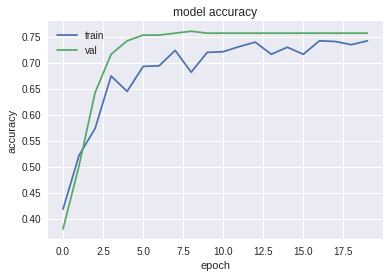

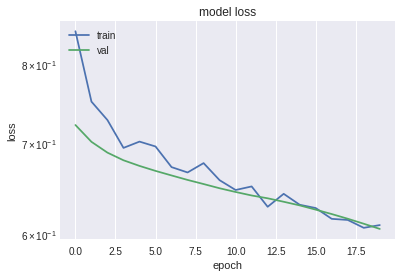

271/271 [==============================] - 0s 63us/step
['loss', 'acc']
('Test loss:', 0.5913260231598717)
('Test accuracy:', 0.7822878230981721)


In [41]:
TrainTestVal(model, feats,
             batch_size=256,train_epochs=20)

#Check the results of the autoencoder
##STOP HERE - This broke, needs to be fixed::


In [18]:
##STOP HERE - This broke, needs to be fixed::

x_all = np.append(feats.x_train,np.append(feats.x_val,feats.x_test,axis=0),axis=0)
y_all = np.append(feats.y_train,np.append(feats.y_val,feats.y_test,axis=0),axis=0)

#encoder input shape and decoder output shape are wrong for the data in the AUTODeep
encoded_data = encoder.predict(x_all)
decoded_data = model.predict(x_all)

print('x_all size: ' + str(x_all.shape))
print('y_all size: ' + str(y_all.shape))
print('encoded_data size: ' + str(encoded_data.shape))
print('decoded_data size: ' + str(decoded_data.shape))

nchans = len(pick_types(epochs.info, meg=False, eeg=True, eog=False))
ntimes = x_all.shape[1]/nchans
x_all = np.reshape(x_all,(x_all.shape[0],ntimes,nchans))
print('x_all size: ' + str(x_all.shape))
print('x_all size: ' + str(decoded_data.shape))

decoded_data = np.reshape(decoded_data,(decoded_data.shape[0],ntimes,nchans))
print(x_all.shape)

n = 10
chan = 0
#epochs.ch_names.index('Pz')
plt.figure(figsize=(10,10))
for i in range(n):
  for j in range(n):
    item_idx = (j*n)+i+1
    ax = plt.subplot(n,n,item_idx)
    plt.plot(x_all[item_idx,:,chan],'b')
    plt.plot(decoded_data[item_idx,:,chan],'r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()




print('x_all Shape: ' + str(x_all.shape))
print('y_all Shape: ' + str(y_all.shape))
chan = 0
#epochs.ch_names.index('Fz')

#divide into conditions
cond_zero_real = x_all[y_all[:,0]==0,:,chan]
cond_one_real = x_all[y_all[:,0]==1,:,chan]
cond_zero_decode = decoded_data[y_all[:,0]==0,:,chan]
cond_one_decode = decoded_data[y_all[:,0]==1,:,chan]

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
zero_err = np.std(cond_zero_real, axis=0)/10
one_err = np.std(cond_one_real, axis=0)/10
ax.fill_between(feats.new_times, np.mean(cond_zero_real, axis=0)-zero_err, np.mean(cond_zero_real, axis=0)+zero_err,color=[.8,.8,1])
ax.plot(feats.new_times,np.mean(cond_zero_real, axis=0),'b',label=event_names[0])
ax.fill_between(feats.new_times, np.mean(cond_one_real, axis=0)-one_err, np.mean(cond_one_real, axis=0)+one_err,color=[1,.8,.8])
ax.plot(feats.new_times,np.mean(cond_one_real, axis=0),'r',label=event_names[1])
plt.title('Real')
ax.legend()

ax = plt.subplot(2,1,2)
zero_err = np.std(cond_zero_decode, axis=0)/10
one_err = np.std(cond_one_decode, axis=0)/10
ax.fill_between(feats.new_times, np.mean(cond_zero_decode, axis=0)-zero_err, np.mean(cond_zero_decode, axis=0)+zero_err,color=[.8,.8,1])
ax.plot(feats.new_times,np.mean(cond_zero_decode, axis=0),'b',label=event_names[0])
ax.fill_between(feats.new_times, np.mean(cond_one_decode, axis=0)-one_err, np.mean(cond_one_decode, axis=0)+one_err,color=[1,.8,.8])
ax.plot(feats.new_times,np.mean(cond_one_decode, axis=0),'r',label=event_names[1])
plt.title('Autogenerated')
ax.legend()
plt.show()


x_all size: (1355, 500)
y_all size: (1355, 2)
encoded_data size: (1355, 8)
decoded_data size: (1355, 500)


ValueError: ignored

#run the autoencoder embedded trials through a NN

Maybe the latent space could represent different components? 
frequency bands? 


Normalizing X


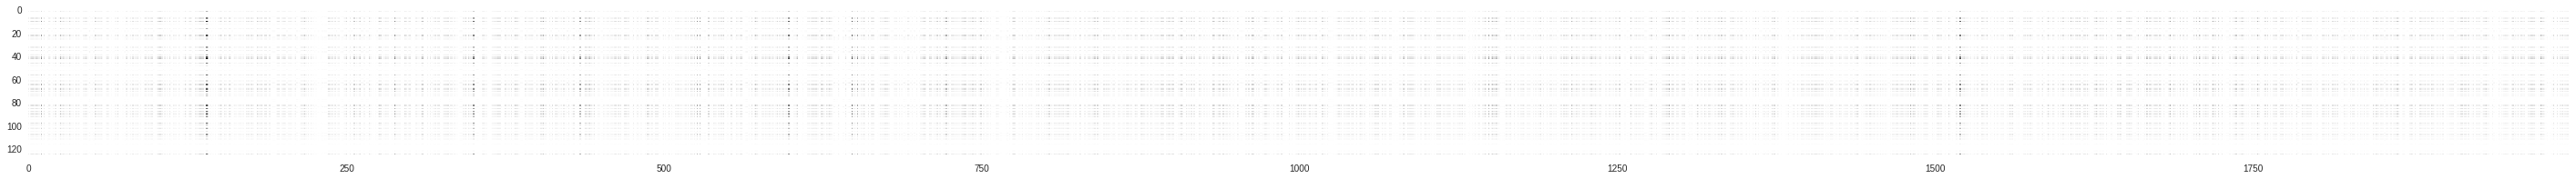

Combined X Shape: (2000, 128, 1)
Combined Y Shape: (2000, 2)
Y Example (should be 1s & 0s): [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
X Range: -0.43102083:19.501577
Input Shape: (128, 1)
('x_train shape:', (1200, 128, 1))
(1200, 'train samples')
(400, 'test samples')
(400, 'validation samples')
Class Weights: [0.62565172 2.48962656]


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

featsA = feats

X= encoded_data 

print('Normalizing X')
X = (X - np.mean(X)) / np.std(X)

fig = plt.figure(figsize=(50,3))
plt.imshow(np.transpose(X),aspect='auto')
Y = y_all
plt.show()
X = np.expand_dims(X,2)

# Split training test and validation data 
test_split = 0.2
val_split = 0.2
random_seed=1017
val_prop = val_split / (1-test_split)
featsA.x_train, featsA.x_test, featsA.y_train, featsA.y_test = train_test_split(X, Y, test_size=test_split,random_state=random_seed) 
featsA.x_train, featsA.x_val, featsA.y_train, featsA.y_val = train_test_split(featsA.x_train, featsA.y_train, test_size=val_prop, random_state=random_seed)

# Compute model input shape
featsA.input_shape = X.shape[1:]

#compute class weights for uneven classes
y_ints = [y.argmax() for y in featsA.y_train]
class_weights = class_weight.compute_class_weight('balanced',
                                               np.unique(y_ints),
                                               y_ints)
#Print some outputs
print('Combined X Shape: ' + str(X.shape))
print('Combined Y Shape: ' + str(Y.shape))
print('Y Example (should be 1s & 0s): ' + str(Y[0:10]))
print('X Range: ' + str(np.min(X)) + ':' + str(np.max(X)))
print('Input Shape: ' + str(featsA.input_shape))
print('x_train shape:', featsA.x_train.shape)
print(featsA.x_train.shape[0], 'train samples')
print(featsA.x_test.shape[0], 'test samples')
print(featsA.x_val.shape[0], 'validation samples')
print('Class Weights: ' + str(featsA.class_weights))



In [0]:
model, encoder = CreateModel(featsA, 
                    model_type='NN')

TrainTestVal(model, featsA,
             batch_size=4,train_epochs=10,
             model_type='NN')

Creating NN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128

KeyboardInterrupt: ignored